In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 13

@author: yaning
"""

import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import math

path = "/home/yaning/Documents/"
np.set_printoptions(threshold=np.inf)
torch.set_printoptions(threshold=float('inf'))

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
with open(path + "fire_data_10p_8f_non_zero.pkl", "rb") as f:
    fire_data = pickle.load(f)

In [4]:
fire_data = torch.tensor(fire_data, device=device)

Test Neurons with ion channels only

In [5]:
pixel_num = 10
feature_num = 8

Input neurons do not need detailed channels or receptors. 

**mp**: Membrane Potential  
**c**: Current

In [6]:
E_num = 20

In [7]:
# only setting the shape
E_cells = torch.zeros(E_num, E_num)

Ion channels on the same neurons share the same gate values (m,n,h)

In [8]:
# initialise state values

m_states = E_cells.clone()
m_states.fill_(0.061956531255774015)

n_states = E_cells.clone()
n_states.fill_(0.3384883478113268)

h_states = E_cells.clone()
h_states.fill_(0.5484107720738856)

initial_states = torch.stack([m_states, n_states, h_states], dim=0)

In [9]:
def update_states(mp, current_states, deltaTms=0.05):
        m_alpha = .1*((25-mp) / (torch.exp((25-mp)/10)-1))
        m_beta = 4*torch.exp(-mp/18)
        n_alpha = .01 * ((10-mp) / (torch.exp((10-mp)/10)-1))
        n_beta = .125*torch.exp(-mp/80)
        h_alpha = .07*torch.exp(-mp/20)
        h_beta = 1/(torch.exp((30-mp)/10)+1)

        alphas = torch.stack([m_alpha, n_alpha, h_alpha], dim=0)
        betas = torch.stack([m_beta, n_beta, h_beta], dim=0)

        alpha_states = alphas*(1-current_states)
        beta_states = betas*current_states

        new_states = current_states + deltaTms*(alpha_states - beta_states)

        return new_states


In [10]:
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

In [11]:
gMax_AMPA = 0.072
gMax_NMDA = 0.0012
gMax_GABA = 0.004

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 140

mg = 0.01

# below parameters are all guesses
u_se = torch.tensor([0.9, 0.9, 0.9])

tau_rec = torch.tensor([12, 12, 12])
tau_pre = torch.tensor([10, 10, 10])
tau_post = torch.tensor([20, 10, 10])
tau_decay = torch.tensor([8, 15, 20])
tau_rise = torch.tensor([10, 7, 7])

learning_rate = 0.7

In [ ]:
# three kinds of receptors
recpetors_cells = torch.zeros(3, E_num, I_num)

In [13]:
# all the dynamic parameters start with 1.
e = recpetors_cells.clone()
e.fill_(1)

w = recpetors_cells.clone()
w.fill_(1)

g_decay = recpetors_cells.clone()
g_decay.fill_(1)

g_rise = recpetors_cells.clone()
g_rise.fill_(1);

In [14]:
mp = recpetors_cells.clone()
mp.fill_(1.3458754117369027);

In [15]:
# receptor states active:1 and inactive:0
activeness = recpetors_cells.clone()
activeness.fill_(0.);

In [16]:
# arrays of having AMPA, NMDA and GABA receptor (1 is have, 0 is not)
# Q: should i use this or not, this slows it down but has more general use
have_AMPA = recpetors_cells.clone()
have_NMDA = recpetors_cells.clone()
have_GABA = recpetors_cells.clone()

In [17]:
have_AMPA.fill_(1)
have_NMDA.fill_(1);

In [18]:
def runge_kutta(f, y0, h, *arg):
    k1 = f(y0, *arg)
    k2 = f(y0 + h*k1/2, *arg)
    k3 = f(y0 + h*k2/2, *arg)
    k4 = f(y0 + h*k3, *arg)

    next = y0 + 1/6*(k1 + 2*k2 + 2*k3 + k4)

    return next

# deri as deriviation 
def e_deri(e, on_off):
    return (1-e)/tau_rec[:,None, None] - u_se[:,None,None]*on_off

def g_decay_deri(g_decay, w, e, on_off):
    return -g_decay/tau_decay[:,None,None] + w*e*on_off

def g_rise_deri(g_rise, w, e, on_off):
    return -g_rise/tau_rise[:,None,None] + w*e*on_off

In [87]:
tau_decay[:, None, None].shape

torch.Size([3, 1, 1])

In [89]:
I_g_decay.shape

torch.Size([3, 10])

In [19]:
def update_gPs(e, g_decay, g_rise, activeness, deltaTms=0.05):
    # update e
    e = runge_kutta(e_deri, e, deltaTms, activeness)

    # update g_decay and g_rise
    # deltaTms * 10 is not good, when try to find the right params need to delete this
    g_decay = runge_kutta(g_decay_deri, g_decay, deltaTms*10, w, e, activeness)
    g_rise = runge_kutta(g_rise_deri, g_rise, deltaTms*10, w, e, activeness)

    gP = g_rise - g_decay

    return e, g_decay, g_rise, gP

Combine ligand-gated receptors with the ion channels

In [20]:
fire_data.shape

torch.Size([100, 10, 10, 8, 6000])

In [ ]:
states = initial_states
mp = I_cells.clone()
mp.fill_(1.3458754117369027)

voltages = []
for t in range(pointCount):

    # should update first because the otherwise it will be just ones (initial values)
    states = update_states(mp, states)
    e, g_decay, g_rise, gP = update_gPs(e, g_decay, g_rise, activeness)

    # print(g_decay)

    # generate currents based on gPs
    AMPA_currents = gMax_AMPA*gP[0]*(mp-rE_AMPA)*activeness[0]
    NMDA_currents = gMax_NMDA*gP[1]*(1/1+mg*torch.exp(-0.062*mp)/3.57)*(mp-rE_NMDA)*activeness[1]
    GABA_currents = gMax_GABA*gP[2]*(mp-rE_GABA)*(-1)*activeness[2]
    
    sodium_currents = gMax_Na*torch.pow(states[0], 3) * states[2]*(mp-rE_Na)
    potassium_currents = gMax_K*torch.pow(states[1], 4)*(mp-rE_K)
    leaky_currents = gMax_leaky*(mp-rE_leaky)

    total_c = - sodium_currents - potassium_currents - leaky_currents - (
        AMPA_currents + NMDA_currents + GABA_currents
    )
    mp = mp + deltaTms*total_c/Cm
    
    

    voltages.append(mp[0][0]-70)

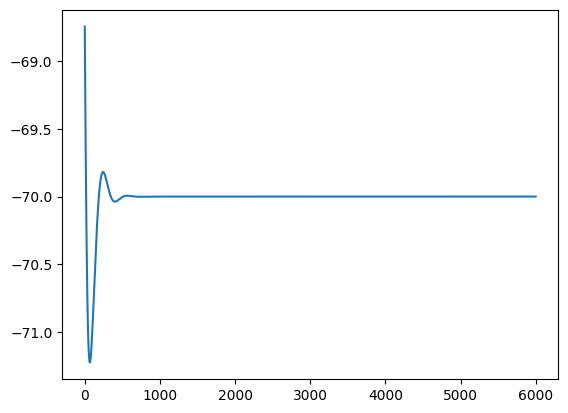

In [22]:
plt.plot(np.arange(pointCount), voltages)

Input layer connects to E and E's own lateral excitatory connections according to euclidean distance

In [23]:
Input_con_E = torch.zeros(pixel_num, pixel_num, feature_num, E_num, E_num, device=device)

In [24]:
# all-to-all  connections
Input_con_E.fill_(1.);

In [25]:
fire_data.shape

torch.Size([100, 10, 10, 8, 6000])

In [26]:
# one picture, one time point
one_data = fire_data[50, :, :, :, 2500]

In [27]:
input_activeness = one_data.float()

In [28]:
# sumed all the fired connections, could use it as a probablity of firing (synapses state change)
E_activeness = torch.einsum('ijkxy,ijk->xy', Input_con_E, input_activeness)

In [48]:
# the later two E_nums are the one sending out the connections/the center
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)

sigma_E_E = 2
max_E_E = 10

for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)

In [52]:
test = E_con_E[:,:,10, 15]

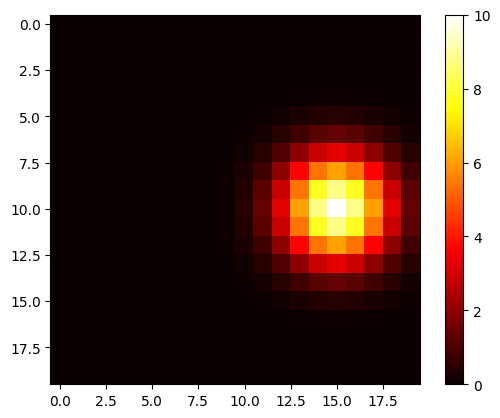

In [53]:
plt.imshow(test.cpu(), cmap='hot')
plt.colorbar() 
plt.show()

Create inhibitory layer and connect it with E and itself

In [29]:
I_num = 10

In [30]:
I_cells = torch.zeros(I_num, device=device)

In [31]:
# E to I connection matrix (p=0.1)
E_con_I = torch.zeros(E_num, E_num, I_num, device=device)

num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element

flat_indices = torch.randperm(num_elements)[:num_ones]

E_con_I.view(-1)[flat_indices] = 1

In [32]:
# I to E connection matrix (p=0.024)
I_con_E = torch.zeros(I_num, E_num, E_num, device=device)

num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element

flat_indices = torch.randperm(num_elements)[:num_ones]

I_con_E.view(-1)[flat_indices] = 1

In [33]:
# I to I self connection (p=0.1)
I_con_I = torch.zeros(I_num, I_num, device=device)

num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element

flat_indices = torch.randperm(num_elements)[:num_ones]

I_con_I.view(-1)[flat_indices] = 1

Connect E to the Output with gaussian weights

In [34]:
Out_num = 5

In [38]:
E_con_Output = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)

sigma_E_Out = 2
max_E_Out = 10
# find the center point from Output to E
ratio = E_num/Out_num

for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Output[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)

In [ ]:
# one cell from Ouput weight connection to E
test = E_con_Output[:,:,2,3]

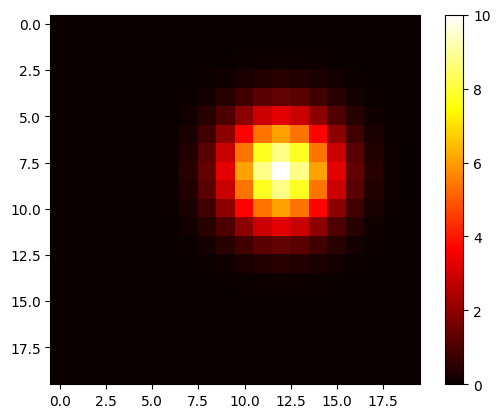

In [46]:
plt.imshow(test.cpu(), cmap='hot')
plt.colorbar() 
plt.show()

run for now, haven't done: weight change/learning and prevent overfiring

In [ ]:
# parameters
gMax_Na = 120
rE_Na = 115

gMax_K = 36
rE_K = -12

gMax_leaky = 0.3
rE_leaky = 10.6

deltaTms = 0.05
Cm = 1
pointCount = fire_data.shape[-1]

gMax_AMPA = 0.072
gMax_NMDA = 0.0012
gMax_GABA = 0.004

rE_AMPA = 70
rE_NMDA = 70
rE_GABA = 140

mg = 0.01

# below parameters are all guesses
u_se = torch.tensor([0.9, 0.9, 0.9])

tau_rec = torch.tensor([12, 12, 12])
tau_pre = torch.tensor([10, 10, 10])
tau_post = torch.tensor([20, 10, 10])
tau_decay = torch.tensor([8, 15, 20])
tau_rise = torch.tensor([10, 7, 7])

learning_rate = 0.7

In [81]:
def initialise(*args):
    cells = torch.zeros(args)
    receptors = torch.zeros(3, *args)

    m_states = cells.clone()
    m_states.fill_(0.061956531255774015)

    n_states = cells.clone()
    n_states.fill_(0.3384883478113268)

    h_states = cells.clone()
    h_states.fill_(0.5484107720738856)

    initial_states = torch.stack([m_states, n_states, h_states], dim=0)

    mp = cells.clone()
    mp.fill_(1.3458754117369027)

    e = receptors.clone()
    e.fill_(1)

    w = receptors.clone()
    w.fill_(1)

    g_decay = receptors.clone()
    g_decay.fill_(1)

    g_rise = receptors.clone()
    g_rise.fill_(1)

    activeness = receptors.clone()
    activeness.fill_(0.)

    return cells, receptors, initial_states, mp, e, w, g_decay, g_rise, activeness

In [82]:
# initialise everything

#----------Input---------------
pixel_num = 10
feature_num = 8

#----------E---------------------
E_num = 20
E_cells, E_receptors, E_states, E_mp, E_e, E_w, E_g_decay, E_g_rise, E_activeness = initialise(E_num, E_num)

#----------I-----------------
I_num = 10
I_cells, I_receptors, I_states, I_mp, I_e, I_w, I_g_decay, I_g_rise, I_activeness = initialise(I_num)

#-----------Output-------------
Out_num = 5
Out_cells, Out_receptors, Out_states, Out_mp, Out_e, Out_w, Out_g_decay, Out_g_rise, Out_activeness = initialise(Out_num, Out_num)

#-----------connection matrices-------------
In_con_E = torch.zeros(pixel_num, pixel_num, feature_num, E_num, E_num, device=device)
# all-to-all  connections
In_con_E.fill_(1.)

# the later two E_nums are the one sending out the connections/the center
E_con_E = torch.zeros(E_num, E_num, E_num, E_num, device=device)
sigma_E_E = 2
max_E_E = 10
for i in range(E_num):
    for j in range(E_num):
        for k in range(E_num):
            for l in range(E_num):
                project_center_x = k
                project_center_y = l

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_E[i,j,k,l] = max_E_E*math.exp(-0.5*(euc_distance/sigma_E_E)**2)


# E to I connection matrix (p=0.1)
E_con_I = torch.zeros(E_num, E_num, I_num, device=device)
num_elements = E_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
E_con_I.view(-1)[flat_indices] = 1

# I to E connection matrix (p=0.024)
I_con_E = torch.zeros(I_num, E_num, E_num, device=device)
num_elements = I_con_E.numel()
num_ones = max(1, int(num_elements * 0.024))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_E.view(-1)[flat_indices] = 1

# I to I self connection (p=0.1)
I_con_I = torch.zeros(I_num, I_num, device=device)
num_elements = I_con_I.numel()
num_ones = max(1, int(num_elements * 0.1))  # Ensure at least 1 element
flat_indices = torch.randperm(num_elements)[:num_ones]
I_con_I.view(-1)[flat_indices] = 1

# E to Out connection
E_con_Output = torch.zeros(E_num, E_num, Out_num, Out_num, device=device)
sigma_E_Out = 2
max_E_Out = 10
# find the center point from Output to E
ratio = E_num/Out_num
for i in range(E_num):
    for j in range(E_num):
        for k in range(Out_num):
            for l in range(Out_num):
                project_center_x = k*ratio
                project_center_y = l*ratio

                euc_distance = math.sqrt((project_center_x - i)**2 + (project_center_y - j)**2)
                E_con_Output[i,j,k,l] = max_E_Out*math.exp(-0.5*(euc_distance/sigma_E_Out)**2)

In [85]:
I_activeness.shape

torch.Size([3, 10])

In [83]:

voltages = []
for t in range(pointCount):

    # should update first because the otherwise it will be just ones (initial values)
    # update one layer after another from the bottom to top (Q: E or I, which should go first)
    # Q: calculate the current right away so it has influence on the next layer or -
    # - keep the time step the same (chose the second for now)
    E_states = update_states(E_mp, E_states)
    E_e, E_g_decay, E_g_rise, E_gP = update_gPs(E_e, E_g_decay, E_g_rise, E_activeness)

    I_states = update_states(I_mp, I_states)
    I_e, I_g_decay, I_g_rise, I_gP = update_gPs(I_e, I_g_decay, I_g_rise, I_activeness)

    Out_states = update_states(Out_mp, Out_states)
    Out_e, Out_g_decay, Out_g_rise, Out_gP = update_gPs(Out_e, Out_g_decay, Out_g_rise, Out_activeness)


    # generate currents based on gPs
    E_AMPA_currents = gMax_AMPA*E_gP[0]*(E_mp-rE_AMPA)*E_activeness[0]
    E_NMDA_currents = gMax_NMDA*E_gP[1]*(1/1+mg*torch.exp(-0.062*E_mp)/3.57)*(E_mp-rE_NMDA)*E_activeness[1]
    E_GABA_currents = gMax_GABA*E_gP[2]*(E_mp-rE_GABA)*(-1)*E_activeness[2]
    
    E_sodium_currents = gMax_Na*torch.pow(E_states[0], 3) * E_states[2]*(E_mp-rE_Na)
    E_potassium_currents = gMax_K*torch.pow(E_states[1], 4)*(E_mp-rE_K)
    E_leaky_currents = gMax_leaky*(E_mp-rE_leaky)

    total_c = - E_sodium_currents - E_potassium_currents - E_leaky_currents - (
        E_AMPA_currents + E_NMDA_currents + E_GABA_currents
    )
    E_mp = E_mp + deltaTms*total_c/Cm

    I_AMPA_currents = gMax_AMPA*I_gP[0]*(I_mp-rE_AMPA)*I_activeness[0]
    I_NMDA_currents = gMax_NMDA*I_gP[1]*(1/1+mg*torch.exp(-0.062*I_mp)/3.57)*(I_mp-rE_NMDA)*I_activeness[1]
    I_GABA_currents = gMax_GABA*I_gP[2]*(I_mp-rE_GABA)*(-1)*I_activeness[2]
    
    I_sodium_currents = gMax_Na*torch.pow(I_states[0], 3) * I_states[2]*(I_mp-rE_Na)
    I_potassium_currents = gMax_K*torch.pow(I_states[1], 4)*(I_mp-rE_K)
    I_leaky_currents = gMax_leaky*(I_mp-rE_leaky)
    
    total_c = - I_sodium_currents - I_potassium_currents - I_leaky_currents - (
        I_AMPA_currents + I_NMDA_currents + I_GABA_currents
    )
    I_mp = I_mp + deltaTms*total_c/Cm

    Out_AMPA_currents = gMax_AMPA*Out_gP[0]*(Out_mp-rE_AMPA)*Out_activeness[0]
    Out_NMDA_currents = gMax_NMDA*Out_gP[1]*(1/1+mg*torch.exp(-0.062*Out_mp)/3.57)*(Out_mp-rE_NMDA)*Out_activeness[1]
    Out_GABA_currents = gMax_GABA*Out_gP[2]*(Out_mp-rE_GABA)*(-1)*Out_activeness[2]
    
    Out_sodium_currents = gMax_Na*torch.pow(Out_states[0], 3) * Out_states[2]*(Out_mp-rE_Na)
    Out_potassium_currents = gMax_K*torch.pow(Out_states[1], 4)*(Out_mp-rE_K)
    Out_leaky_currents = gMax_leaky*(Out_mp-rE_leaky)

    total_c = - Out_sodium_currents - Out_potassium_currents - Out_leaky_currents - (
        Out_AMPA_currents + Out_NMDA_currents + Out_GABA_currents
    )
    Out_mp = Out_mp + deltaTms*total_c/Cm
    
    

    voltages.append(Out_mp[0][0]-70)

RuntimeError: The size of tensor a (20) must match the size of tensor b (10) at non-singleton dimension 2